In [8]:
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
import pandas as pd
import pyfaidx
from collections import Counter, defaultdict, OrderedDict
#from modisco.visualization import viz_sequence
import logomaker
from copy import deepcopy
from tqdm import tqdm
from tqdm import tnrange
import deepdish
import pyBigWig
import tqdm
import sys
import pyfaidx
import pysam
sys.path.append("../../../chrombpnet/")
from training.utils.losses import multinomial_nll
from training.utils.one_hot import dna_to_one_hot
from evaluation.interpret.shap_utils import *
#from utils.data_utils import load_test_data, get_seq
#from training.utils.data_utils import get_seq, get_seq_cts
import matplotlib as plt
plt.rc('figure', max_open_warning = 0)
import seaborn as sns
#import hdf5plugin
import shap
import glob
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import sklearn.cluster
from scipy.stats import chi2_contingency

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import pyBigWig
#import anndata
import matplotlib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import sys
sys.path.append("../../../src/")
custom_objects={"tf":tf, "multinomial_nll":multinomial_nll}    
get_custom_objects().update(custom_objects)
from tensorflow import keras
#import proplot as pplt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import 
import timeit

In [9]:
def motifs_nonoverlap(motif1, motif2):
    return motif1['end'] - motif2['start'] < 3 or motif2['end'] - motif1['start'] < 3
def count_co_occurrences(df):
    co_occurrences_count_per_peak = defaultdict(lambda: defaultdict(int))

    grouped_df = df.groupby('peak')

    for group_name, group_df in grouped_df:
        n = len(group_df)

        for i in range(n):
            for j in range(i + 1, n):
                motif1 = group_df.iloc[i]
                motif2 = group_df.iloc[j]

                if motif1['key'] != motif2['key'] and motifs_nonoverlap(motif1, motif2):
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")

                if motif1['key'] == motif2['key']:
                    mpair = tuple(sorted((motif1['key'], motif2['key'])))  # Make a tuple of sorted keys to ensure consistent counting
                    co_occurrences_count_per_peak[mpair][group_name] += 1
                    #print(f"Co-occurrence: {motif1['key']} at {motif1['peak']} with {motif1['start']} - {motif1['end']} and {motif2['key']} at {motif2['peak']} with {motif2['start']} - {motif2['end']}")


    # Now we need to collapse the nested dictionaries to return only the frequencies
    # of group names for each motif pair
    result = defaultdict(dict)
    for motif_pair, peak_counts in co_occurrences_count_per_peak.items():
        for peak, count in peak_counts.items():
            result[motif_pair][peak] = count

    return result

In [10]:
### This function is to calculate unfiltered
def unfiltered_count_co_occurrences(peak_hit_counts):
    """
    From an N x M (peaks by motifs) array of hit counts, returns
    an M x M array of counts (i.e. how many times two motifs occur
    together in the same peak). For the diagonal entries, we require
    that motif occur at least twice in a peak to be counted.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_motifs = peak_hit_indicators.shape[1]
    count_matrix = np.zeros((num_motifs, num_motifs), dtype=int)
    for i in range(num_motifs):
        for j in range(i):
            pair_col = np.sum(peak_hit_indicators[:, [i, j]], axis=1)
            count = np.sum(pair_col == 2)
            count_matrix[i, j] = count
            count_matrix[j, i] = count
        count_matrix[i, i] = np.sum(peak_hit_counts[:, i] >= 2)
    return count_matrix

In [11]:
lst_keys =[]
lst_values = []
with open(''./motif_clustering_data/all_motif_clusters.annot.meme', 'r') as f:
    for l in f.readlines():
            if l.startswith("MOTIF"):
                l = l.split()[-1].split(' ')[0]
                lst_values.append(l)
                l = l.split()[-1].split('|')[0]
                lst_keys.append(l)

res = {lst_keys[i]: lst_values[i] for i in range(len(lst_keys))}

In [12]:
def check_motif_within_peak(motif_start, motif_end, peak_start, peak_end):
    return peak_start <= motif_start <= motif_end <= peak_end

In [13]:
#cmap1 = pplt.Colormap('Blues7_r', 'Reds', name='Diverging', save=True)
custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list( 'custom',plt.get_cmap('Reds')(np.linspace(0,1,100)**(2)) )
custom_cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list( '',['white',*plt.cm.Reds((np.linspace(0,1,100)**(2)))])

In [14]:
## Highly variable neural motifs 
Mlig_order = ['WC_1252','WC_0722','WC_0285','WC_0632','WC_0394',
              'JC_0190','WC_0335','WC_1590','WC_1383','WC_0524',
              'WC_0105','JC_0318','JC_0070','JC_0158','WC_0001',
              'WC_0509','JC_0078','JC_0384','WC_1093','WC_0470',
              'WC_0597','JC_0101','WC_0786','JC_0397','WC_1641',
              'WC_1260','WC_0966','WC_0398','JC_0264','JC_0306',
              'WC_1134','WC_1565','WC_1784','WC_1294','JC_0348',
              'JC_0030','JC_0147','WC_0226','WC_0107','JC_0004',
              'JC_0280','JC_0096','JC_0141','JC_0320','JC_0389',
              'WC_1917','WC_1796','WC_1694','WC_1470','WC_1458',
              'WC_1253','WC_1125','WC_1114','WC_0975','WC_0919',
              'WC_0855','WC_0629','WC_0185','WC_0174','WC_0169',
              'JC_0212','JC_0368','WC_0925','WC_1648','WC_0948',
              'WC_1033','WC_1290','WC_0515','JC_0012','JC_0331',
              'WC_1455','WC_1292','WC_0519','WC_0061','WC_0011',
              'JC_0325','JC_0099','JC_0106','WC_1156','JC_0161',
              'JC_0182','JC_0001','JC_0115','WC_1518','WC_1309',
              'WC_1236','WC_1078','JC_0255','JC_0250','JC_0166',
              'JC_0079','JC_0067','JC_0069','WC_0928','JC_0256',
              'JC_0294','WC_0247','JC_0065','JC_0024','JC_0047',
              'WC_1576','WC_0969','JC_0072','JC_0142','WC_2006',
              'WC_1176','WC_1013','WC_1010','WC_0968','WC_0962',
              'WC_0725','WC_0648','WC_0472','WC_0410','WC_0351',
              'WC_0324','WC_0031','JC_0324','JC_0224','JC_0218',
              'JC_0197','JC_0193','JC_0117','JC_0062','JC_0010',
              'JC_0018','JC_0410','JC_0131','JC_0297','WC_0908',
              'JC_0315','JC_0129','JC_0014','JC_0073','JC_0006',
              'JC_0058','JC_0066','JC_0080','JC_0105','JC_0130',
              'JC_0170','JC_0172','JC_0247','JC_0263','WC_0102',
              'WC_0193','WC_0423','WC_0651','WC_0921','WC_0992',
              'WC_0993','WC_1174','WC_1256','WC_1528','WC_1573']

### S. mansoni

In [16]:
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Sman/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
neural_final = pd.read_csv('./ChromBPNet/Peaks/schisto_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=2750)
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]


In [70]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

## UnFiltered_one
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [71]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Sman/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

353.5217336610003 seconds


In [17]:
schisto_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Sman/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t",index_col=0)

schisto_neural['JC_0166'] = 1
schisto_neural['JC_0389'] = 1 

motif_notin = 'JC_0166'
new_row = pd.Series(1, index=schisto_neural.columns, name=motif_notin)
schisto_neural = schisto_neural.append(new_row)
motif_notin3 = 'JC_0389'
new_row3 = pd.Series(1, index=schisto_neural.columns, name=motif_notin3)
schisto_neural = schisto_neural.append(new_row3)

schisto_neural = schisto_neural.loc[Mlig_order,Mlig_order]
schisto_neural_counts = schisto_neural.to_numpy()

/tmp/ipykernel_6379/2726601483.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  schisto_neural = schisto_neural.append(new_row)
/tmp/ipykernel_6379/2726601483.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  schisto_neural = schisto_neural.append(new_row3)


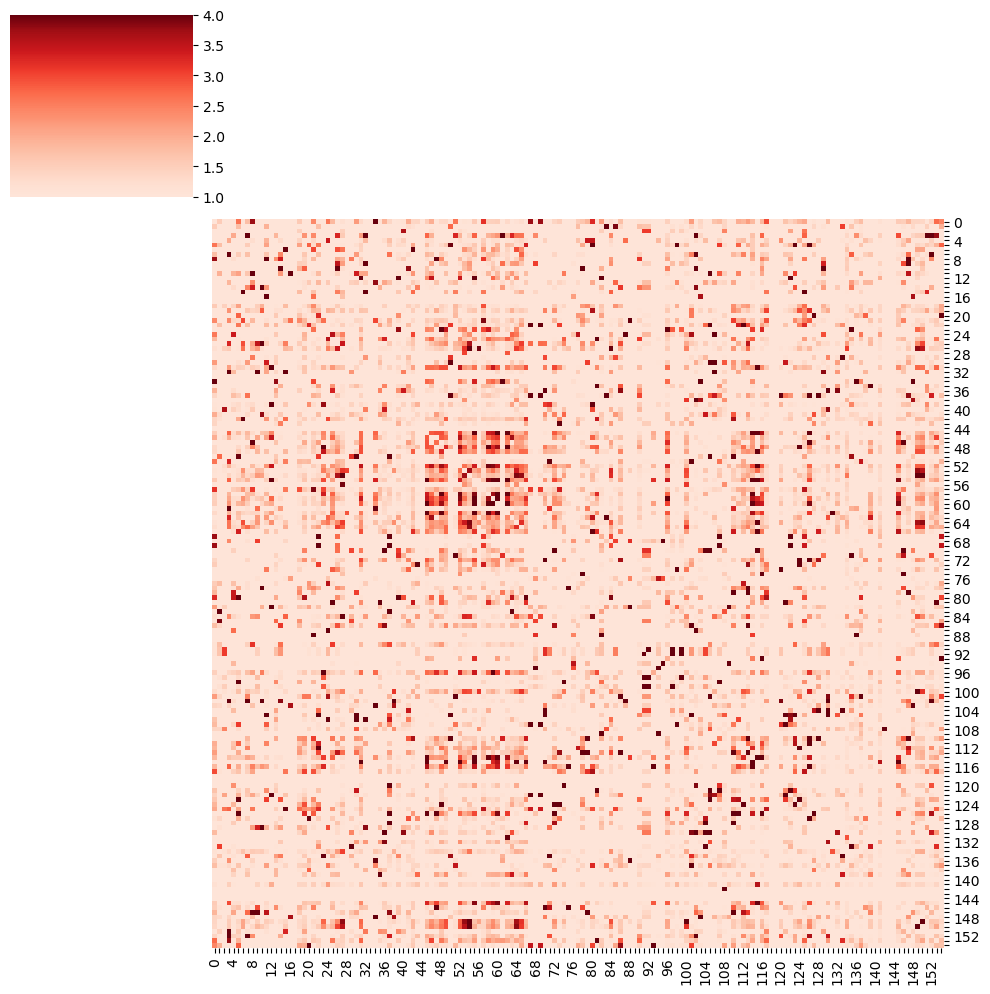

In [10]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Sman = sns.clustermap(schisto_neural_counts,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Sman.ax_heatmap.set_xticks(np.arange(schisto_neural_counts.shape[0])+0.5)
Sman.ax_heatmap.set_yticks(np.arange(schisto_neural_counts.shape[0])+0.5)
plt.tight_layout()
plt.savefig("./Plots/EDFig7/PanelED7c_Sman.svg",format="svg")
plt.show()

### S. mediterranea

In [75]:
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Smed/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
neural_final = pd.read_csv('./ChromBPNet/Peaks/pl_Neural_final.csv',sep=',',index_col=0)
neural = neural[neural.peak.isin(neural_final.Peak)]
neural_sub= neural[["peak", "start","end","key"]]


In [83]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

## UnFiltered_one
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [84]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Smed/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

212.01800048899895 seconds


In [18]:
Smed_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Smed/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t",index_col=0)
['JC_0325', 'JC_0170']
Smed_neural['JC_0325'] = 1
Smed_neural['JC_0170'] = 1

motif_notin = 'JC_0325'
new_row = pd.Series(1, index=Smed_neural.columns, name=motif_notin)
Smed_neural = Smed_neural.append(new_row)
motif_notin2 = 'JC_0170'
new_row2 = pd.Series(1, index=Smed_neural.columns, name=motif_notin2)
Smed_neural = Smed_neural.append(new_row2)

Smed_neural = Smed_neural.loc[Mlig_order,Mlig_order]
Smed_neural_counts = Smed_neural.to_numpy()

/tmp/ipykernel_6379/2426240145.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Smed_neural = Smed_neural.append(new_row)
/tmp/ipykernel_6379/2426240145.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Smed_neural = Smed_neural.append(new_row2)


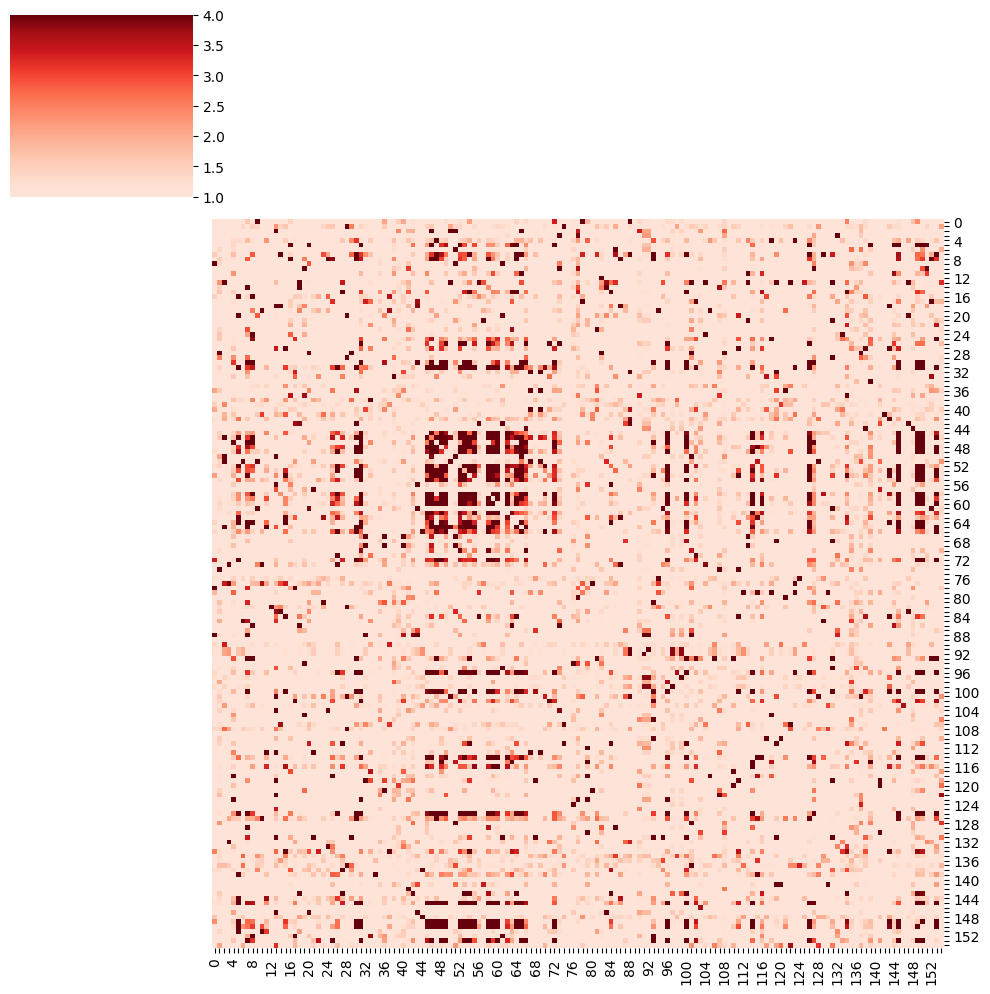

In [118]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Smed_heatmap = sns.clustermap(Smed_neural_counts,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Smed_heatmap.ax_heatmap.set_xticks(np.arange(Smed_neural_counts.shape[1])+0.5)
Smed_heatmap.ax_heatmap.set_yticks(np.arange(Smed_neural_counts.shape[0])+0.5)

plt.tight_layout()
plt.savefig("./Plots/EDFig7/PanelED7c_Smed.svg",format="svg")
plt.show()

### M. lignano

In [88]:
neural = pd.read_csv('./ChromBPNet/Motif_filtration/Mlig/neural_mean_motifs_SHAP_filtered_self_cooccur_filtration.tsv',sep="\t")
neural['peak'] = neural.peak_chrom + ':' + (neural.peak_start+1).astype(str) + '-' + neural.peak_end.astype(str)
neural_final = pd.read_csv('./ChromBPNet/Peaks/Mlig_Neural_final.csv',sep=',',index_col=0)
neural_final_sub = neural_final.sort_values(by='prob_da',ascending=False)
neural_final_sub = neural_final_sub.head(n=4000)
neural = neural[neural.peak.isin(neural_final_sub.Peak)]
neural_sub= neural[["peak", "start","end","key"]]


In [95]:
### Unfiltered cooccurence, what I need is an input of peakxmotif matrix 
neural_sub_table = neural_sub.groupby(['peak','key']).size().fillna(0).unstack(fill_value=0)
neural_sub_counts = neural_sub_table.to_numpy()

unfiltered_neural = unfiltered_count_co_occurrences(neural_sub_counts)
unfiltered_neural = pd.DataFrame(unfiltered_neural)
unfiltered_neural.index = neural_sub_table.columns.tolist()
unfiltered_neural.columns = neural_sub_table.columns.tolist()

## UnFiltered_one
co_occurrences_df = unfiltered_neural
motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_unfiltered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

In [96]:
# Count co-occurrences in the dataframe
start_time = timeit.default_timer()
co_occurrences_count = count_co_occurrences(neural_sub)

# Convert the result to a dataframe
co_occurrences_df = pd.DataFrame(index=neural_sub['key'].unique(), columns=neural_sub['key'].unique(), data=0)

# Update the dataframe with the co-occurrence counts
for (motif1, motif2), count in co_occurrences_count.items():
    co_occurrences_df.loc[motif1, motif2] = len(count)
    co_occurrences_df.loc[motif2, motif1] = len(count)

neural = neural_sub.groupby(['key','peak']).size()

motif_list = list(co_occurrences_df.columns)
neural_long = pd.melt(co_occurrences_df, value_vars=motif_list,value_name='Num_Peaks',ignore_index=False).reset_index()
neural_long.columns = ['motif_1','motif_2','Num_Peaks']
neural_l1 = neural_long[neural_long["motif_1"].isin(Mlig_order)]
neural_l1_l2 = neural_l1[neural_l1["motif_2"].isin(Mlig_order)]
neural_filtered_n = pd.pivot(neural_l1_l2, index='motif_1', columns='motif_2', values='Num_Peaks').fillna(0)

delta = neural_unfiltered_n.sub(neural_filtered_n)

for index,row in neural_filtered_n.iterrows():
    for motif in neural_filtered_n.columns:
        motif1 = index
        #print(motif1)
        motif2 = motif
        #print(motif2)
        motif1_total = neural.loc[motif1].shape[0] - delta.loc[motif1,motif2]
        #print('motif1_total:',motif1_total)
        motif2_total = neural.loc[motif2].shape[0] - delta.loc[motif1,motif2]
        #print('motif2_total:',motif2_total)
        N = np.unique(neural_sub.peak).shape[0] # species specific peaks in filtered h5ad 
        fA = motif1_total/N
        #print('fA:',fA)
        fB = motif2_total/N
        #print('fB:',fB)
        expected = fA*fB*N
        #print('expected:', expected)
        #print('hits:',row[motif])
        if (expected < 2) and ((row[motif]) < 2):
            frac = 1
        else: 
            frac = ((row[motif])* N)/((motif1_total)*(motif2_total))
        #print('enrich:',frac)
        neural_filtered_n.at[index,motif] = frac
neural_filtered_n.to_csv("./ChromBPNet/Motif_filtration/Mlig/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t")

print(timeit.default_timer() - start_time, "seconds") 

258.44921285098826 seconds


In [19]:
Mlig_neural = pd.read_csv("./ChromBPNet/Motif_filtration/Mlig/neural_variable_motifs_enriched_selfcooccur_fixed.tsv",sep="\t",index_col=0)
Mlig_neural['JC_0166'] = 1
Mlig_neural['JC_0012'] = 1
Mlig_neural['JC_0297'] = 1
Mlig_neural['JC_0218'] = 1
Mlig_neural['WC_1253'] = 1
Mlig_neural['JC_0117'] = 1

motif_notin = 'JC_0166'
new_row = pd.Series(1, index=Mlig_neural.columns, name=motif_notin)
Mlig_neural = Mlig_neural.append(new_row)
motif_notin2 = 'JC_0012'
new_row2 = pd.Series(1, index=Mlig_neural.columns, name=motif_notin2)
Mlig_neural = Mlig_neural.append(new_row2)
motif_notin4 = 'JC_0297'
new_row4 = pd.Series(1, index=Mlig_neural.columns, name=motif_notin4)
Mlig_neural = Mlig_neural.append(new_row4)
motif_notin5 = 'JC_0218'
new_row5 = pd.Series(1, index=Mlig_neural.columns, name=motif_notin5)
Mlig_neural = Mlig_neural.append(new_row5)
motif_notin6 = 'WC_1253'
new_row6 = pd.Series(1, index=Mlig_neural.columns, name=motif_notin6)
Mlig_neural = Mlig_neural.append(new_row6)
motif_notin7 = 'JC_0117'
new_row7 = pd.Series(1, index=Mlig_neural.columns, name=motif_notin7)
Mlig_neural = Mlig_neural.append(new_row7)

Mlig_neural = Mlig_neural.loc[Mlig_order,Mlig_order]
Mlig_neural_counts = Mlig_neural.to_numpy()

/tmp/ipykernel_6379/805184462.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Mlig_neural = Mlig_neural.append(new_row)
/tmp/ipykernel_6379/805184462.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Mlig_neural = Mlig_neural.append(new_row2)
/tmp/ipykernel_6379/805184462.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Mlig_neural = Mlig_neural.append(new_row4)
/tmp/ipykernel_6379/805184462.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Mlig_neural = Mlig_neural.append(new_row5)
/tmp/ipykernel_6379/805184462.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

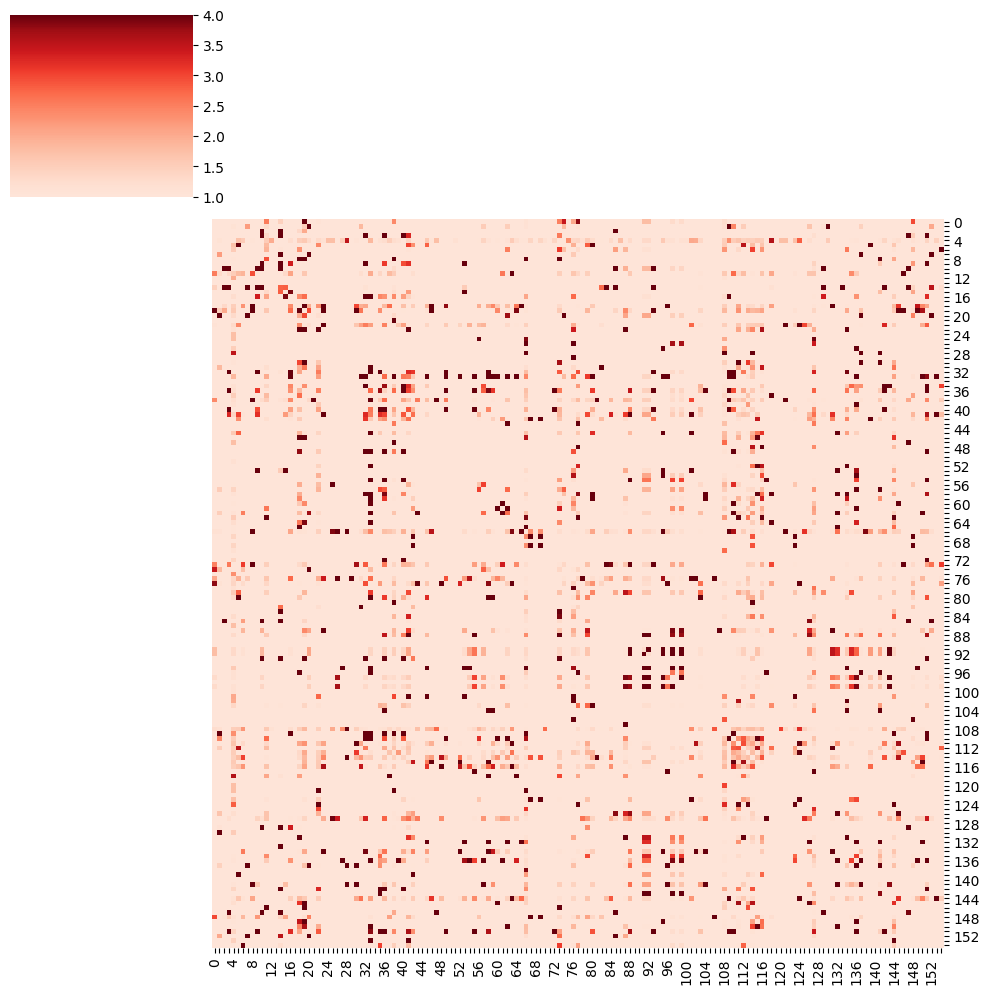

In [111]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
Mlig_heatmap = sns.clustermap(Mlig_neural_counts,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
Mlig_heatmap.ax_heatmap.set_xticks(np.arange(Mlig_neural_counts.shape[1])+0.5)
Mlig_heatmap.ax_heatmap.set_yticks(np.arange(Mlig_neural_counts.shape[0])+0.5)

# Mlig_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
# Mlig_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig7/PanelED7c_Mlig.svg",format="svg")
plt.show()

### Calculating minimum

In [20]:
min_merged = np.concatenate((Mlig_neural_counts[:,:,None],Smed_neural_counts[:,:,None],schisto_neural_counts[:,:,None]),axis=2).min(2)

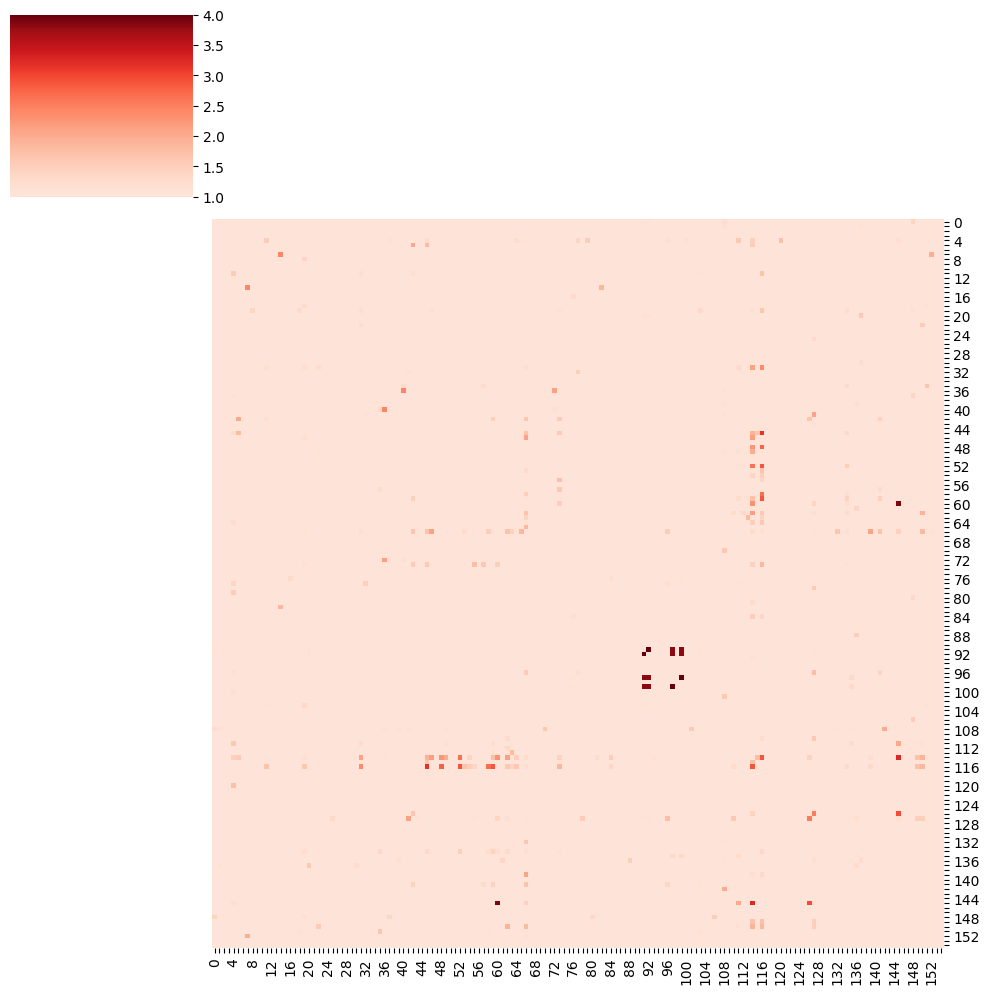

In [126]:
cbar_kws=dict(use_gridspec=False,pad=0.01,shrink=0.25)
minimum_heatmap = sns.clustermap(min_merged,robust=True,cmap=custom_cmap,row_cluster=False,col_cluster=False,vmin=1,vmax=4,center=1.8,figsize=(10, 10),cbar_kws=cbar_kws)#,vmax=10)#row_linkage = zmuscle, col_linkage = zmuscle, robust=True,cmap='Blues',vmax=10)
minimum_heatmap.ax_heatmap.set_xticks(np.arange(min_merged.shape[1])+0.5)
minimum_heatmap.ax_heatmap.set_yticks(np.arange(min_merged.shape[0])+0.5)

#minimum_heatmap.ax_heatmap.set_xticklabels( neural_muscle_motifs, rotation=90 ) 
#minimum_heatmap.ax_heatmap.set_yticklabels( pan_neural_muscle, rotation=0 ) 
plt.tight_layout()
plt.savefig("./Plots/EDFig7/PanelED7c_minimum.svg",format="svg")
plt.show()

/tmp/ipykernel_6379/2016502659.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='Value', data=df, ax=ax, palette='viridis')


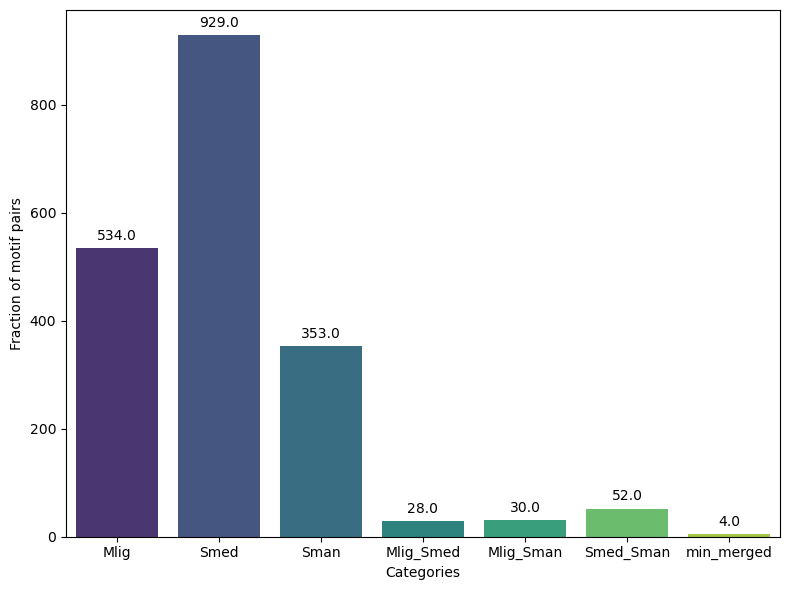

In [28]:
### Minimum between two species (Mlig_Smed, Mlig_Sman, Smed_Sman) 
min_Mlig_Smed = np.concatenate((Mlig_neural_counts[:,:,None],Smed_neural_counts[:,:,None]),axis=2).min(2)
min_Mlig_Sman = np.concatenate((Mlig_neural_counts[:,:,None],schisto_neural_counts[:,:,None]),axis=2).min(2)
min_Smed_Sman = np.concatenate((Smed_neural_counts[:,:,None],schisto_neural_counts[:,:,None]),axis=2).min(2)

thres = 4 
Mlig_neural_sum = (Mlig_neural_counts > thres).sum()
Smed_neural_sum = (Smed_neural_counts > thres).sum()
Sman_neural_sum = (schisto_neural_counts > thres).sum()
Mlig_Smed_min = (min_Mlig_Smed > thres).sum()
Mlig_Sman_min = (min_Mlig_Sman > thres).sum()
Smed_Sman_min = (min_Smed_Sman > thres).sum()
min_merged_sum = (min_merged > thres).sum()

data = {
    'Category': ['Mlig', 'Smed', 'Sman', 'Mlig_Smed','Mlig_Sman', 'Smed_Sman', 'min_merged'],
    'Value': [Mlig_neural_sum, Smed_neural_sum, Sman_neural_sum, Mlig_Smed_min,
              Mlig_Sman_min, Smed_Sman_min,min_merged_sum]
}
df = pd.DataFrame(data)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create bar plot using Seaborn
sns.barplot(x='Category', y='Value', data=df, ax=ax, palette='viridis')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

# Add titles and labels
ax.set_xlabel('Categories')
ax.set_ylabel('Fraction of motif pairs')

# Show plot
plt.tight_layout()
plt.savefig("./Plots/Fig3/Panel3c_bottom.svg")

plt.show()